# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

#mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

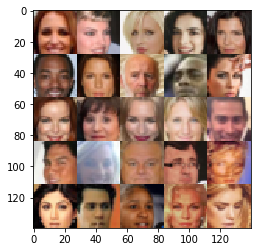

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name = "input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = "input_z")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")

    return input_real, input_z, learning_rate 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
        # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        # input size 28*28*3
        layer1 = tf.layers.conv2d(images, 64, 5, strides = 2,padding = 'same')
        relu1 = tf.maximum(0.2*layer1,layer1)

        # 14*14*64
        layer2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        layers = tf.layers.batch_normalization(layer2, training = True)
        relu2 = tf.maximum(0.2*layer2,layer2)

        # 7*7*128
        layer3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training= True)
        relu3 = tf.maximum(0.2*layer3,layer3)

        flatten_layer = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flatten_layer,1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        layer1 = tf.layers.dense(z,7*7*512);
        layer1 = tf.reshape(layer1,(-1,7,7,512))
        relu1 = tf.maximum(0.2*layer1,layer1)
        
        # input 7*7*512
        layer2 = tf.layers.conv2d_transpose(relu1,256,5,strides=1,padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        relu2 = tf.maximum(0.2*layer2,layer2)
        # output 7*7*256
        
        layer3 = tf.layers.conv2d_transpose(relu2,128,5,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        relu3  = tf.maximum(0.2*layer3,layer3)
        # 7*7*128
        
        logits = tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=2,padding='same')
        output = tf.tanh(logits)
        
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                
                if step%10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}".format(epoch_i),
                          "The No. {} steps loss_d is {}".format(step,train_loss_d),
                          "The No. {} steps loss_g is {}".format(step,train_loss_g))
                    
                if step%100==0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                    
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [15]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 0 The No. 10 steps loss_d is 0.4958476424217224 The No. 10 steps loss_g is 3.634113311767578
Epoch 0 The No. 20 steps loss_d is 0.7558718919754028 The No. 20 steps loss_g is 1.6051383018493652
Epoch 0 The No. 30 steps loss_d is 0.9318548440933228 The No. 30 steps loss_g is 1.539865493774414
Epoch 0 The No. 40 steps loss_d is 0.4213811457157135 The No. 40 steps loss_g is 4.691340446472168
Epoch 0 The No. 50 steps loss_d is 1.0933996438980103 The No. 50 steps loss_g is 1.5784246921539307
Epoch 0 The No. 60 steps loss_d is 0.6713694930076599 The No. 60 steps loss_g is 2.342517852783203
Epoch 0 The No. 70 steps loss_d is 1.3589937686920166 The No. 70 steps loss_g is 0.6566328406333923
Epoch 0 The No. 80 steps loss_d is 0.6191128492355347 The No. 80 steps loss_g is 2.300375461578369
Epoch 0 The No. 90 steps loss_d is 0.569953203201294 The No. 90 steps loss_g is 2.6890320777893066
Epoch 0 The No. 100 steps loss_d is 0.5244097709655762 The No. 100 steps loss_g is 3.445058584213257


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 110 steps loss_d is 0.6234861612319946 The No. 110 steps loss_g is 1.7219922542572021
Epoch 0 The No. 120 steps loss_d is 0.5506545305252075 The No. 120 steps loss_g is 2.370507001876831
Epoch 0 The No. 130 steps loss_d is 0.520155668258667 The No. 130 steps loss_g is 2.6969099044799805
Epoch 0 The No. 140 steps loss_d is 0.5532276630401611 The No. 140 steps loss_g is 2.1545159816741943
Epoch 0 The No. 150 steps loss_d is 0.4419776201248169 The No. 150 steps loss_g is 4.4943952560424805
Epoch 0 The No. 160 steps loss_d is 0.41795477271080017 The No. 160 steps loss_g is 4.3971662521362305
Epoch 0 The No. 170 steps loss_d is 1.7376052141189575 The No. 170 steps loss_g is 0.4537707567214966
Epoch 0 The No. 180 steps loss_d is 0.6136488318443298 The No. 180 steps loss_g is 2.208352565765381
Epoch 0 The No. 190 steps loss_d is 0.4952821731567383 The No. 190 steps loss_g is 2.733180522918701
Epoch 0 The No. 200 steps loss_d is 0.6297541856765747 The No. 200 steps loss_g is 2.

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 210 steps loss_d is 0.4899110794067383 The No. 210 steps loss_g is 5.080761909484863
Epoch 0 The No. 220 steps loss_d is 0.43452921509742737 The No. 220 steps loss_g is 3.334693431854248
Epoch 0 The No. 230 steps loss_d is 0.6249666810035706 The No. 230 steps loss_g is 3.314236879348755
Epoch 0 The No. 240 steps loss_d is 0.44890761375427246 The No. 240 steps loss_g is 3.2675352096557617
Epoch 0 The No. 250 steps loss_d is 0.4445657730102539 The No. 250 steps loss_g is 3.7178597450256348
Epoch 0 The No. 260 steps loss_d is 0.503080427646637 The No. 260 steps loss_g is 2.806734323501587
Epoch 0 The No. 270 steps loss_d is 0.43154042959213257 The No. 270 steps loss_g is 5.234832763671875
Epoch 0 The No. 280 steps loss_d is 0.8251751661300659 The No. 280 steps loss_g is 2.3572916984558105
Epoch 0 The No. 290 steps loss_d is 1.6979176998138428 The No. 290 steps loss_g is 0.7586804032325745
Epoch 0 The No. 300 steps loss_d is 0.5997545719146729 The No. 300 steps loss_g is 2.

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 310 steps loss_d is 0.6628453731536865 The No. 310 steps loss_g is 1.9781192541122437
Epoch 0 The No. 320 steps loss_d is 0.5093638300895691 The No. 320 steps loss_g is 2.889979839324951
Epoch 0 The No. 330 steps loss_d is 2.187229871749878 The No. 330 steps loss_g is 4.629133224487305
Epoch 0 The No. 340 steps loss_d is 1.3103229999542236 The No. 340 steps loss_g is 0.801901638507843
Epoch 0 The No. 350 steps loss_d is 0.6508000493049622 The No. 350 steps loss_g is 1.6939224004745483
Epoch 0 The No. 360 steps loss_d is 0.7349764108657837 The No. 360 steps loss_g is 1.3539726734161377
Epoch 0 The No. 370 steps loss_d is 0.7774642705917358 The No. 370 steps loss_g is 1.594148874282837
Epoch 0 The No. 380 steps loss_d is 0.7414098381996155 The No. 380 steps loss_g is 2.184176445007324
Epoch 0 The No. 390 steps loss_d is 0.4377598464488983 The No. 390 steps loss_g is 3.525362491607666
Epoch 0 The No. 400 steps loss_d is 0.9753697514533997 The No. 400 steps loss_g is 1.7337

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 410 steps loss_d is 0.9156397581100464 The No. 410 steps loss_g is 1.1842033863067627
Epoch 0 The No. 420 steps loss_d is 0.838087797164917 The No. 420 steps loss_g is 1.4696252346038818
Epoch 0 The No. 430 steps loss_d is 0.48945122957229614 The No. 430 steps loss_g is 2.478865146636963
Epoch 0 The No. 440 steps loss_d is 0.585050106048584 The No. 440 steps loss_g is 2.00949764251709
Epoch 0 The No. 450 steps loss_d is 0.47262629866600037 The No. 450 steps loss_g is 2.792135715484619
Epoch 0 The No. 460 steps loss_d is 1.5718040466308594 The No. 460 steps loss_g is 0.5844554901123047
Epoch 1 The No. 10 steps loss_d is 0.6398767828941345 The No. 10 steps loss_g is 2.4841647148132324
Epoch 1 The No. 20 steps loss_d is 0.4459128975868225 The No. 20 steps loss_g is 3.1258139610290527
Epoch 1 The No. 30 steps loss_d is 8.004339218139648 The No. 30 steps loss_g is 9.104913711547852
Epoch 1 The No. 40 steps loss_d is 0.9908971190452576 The No. 40 steps loss_g is 0.98324698209

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 110 steps loss_d is 0.45900827646255493 The No. 110 steps loss_g is 2.7799434661865234
Epoch 1 The No. 120 steps loss_d is 0.592440128326416 The No. 120 steps loss_g is 2.0228257179260254
Epoch 1 The No. 130 steps loss_d is 0.8512930870056152 The No. 130 steps loss_g is 2.989781379699707
Epoch 1 The No. 140 steps loss_d is 0.9265618324279785 The No. 140 steps loss_g is 1.3275822401046753
Epoch 1 The No. 150 steps loss_d is 0.6523808240890503 The No. 150 steps loss_g is 1.6739165782928467
Epoch 1 The No. 160 steps loss_d is 0.5008460879325867 The No. 160 steps loss_g is 2.2760939598083496
Epoch 1 The No. 170 steps loss_d is 0.4760339856147766 The No. 170 steps loss_g is 2.643342971801758
Epoch 1 The No. 180 steps loss_d is 0.4380490183830261 The No. 180 steps loss_g is 2.856205463409424
Epoch 1 The No. 190 steps loss_d is 0.4105597138404846 The No. 190 steps loss_g is 3.7466962337493896
Epoch 1 The No. 200 steps loss_d is 1.109663486480713 The No. 200 steps loss_g is 2.8

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 210 steps loss_d is 0.5601610541343689 The No. 210 steps loss_g is 2.121778964996338
Epoch 1 The No. 220 steps loss_d is 0.553898811340332 The No. 220 steps loss_g is 2.1170711517333984
Epoch 1 The No. 230 steps loss_d is 0.5148630142211914 The No. 230 steps loss_g is 2.7726709842681885
Epoch 1 The No. 240 steps loss_d is 1.483724594116211 The No. 240 steps loss_g is 0.7046314477920532
Epoch 1 The No. 250 steps loss_d is 0.5162542462348938 The No. 250 steps loss_g is 2.7923192977905273
Epoch 1 The No. 260 steps loss_d is 0.39153096079826355 The No. 260 steps loss_g is 5.140528678894043
Epoch 1 The No. 270 steps loss_d is 0.3837466835975647 The No. 270 steps loss_g is 3.8072900772094727
Epoch 1 The No. 280 steps loss_d is 0.43775153160095215 The No. 280 steps loss_g is 2.91035795211792
Epoch 1 The No. 290 steps loss_d is 0.37464573979377747 The No. 290 steps loss_g is 4.034541130065918
Epoch 1 The No. 300 steps loss_d is 0.5915000438690186 The No. 300 steps loss_g is 2.0

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 310 steps loss_d is 0.7236800193786621 The No. 310 steps loss_g is 1.6404781341552734
Epoch 1 The No. 320 steps loss_d is 1.0982005596160889 The No. 320 steps loss_g is 1.3704476356506348
Epoch 1 The No. 330 steps loss_d is 0.9602015614509583 The No. 330 steps loss_g is 1.0707861185073853
Epoch 1 The No. 340 steps loss_d is 0.5661503672599792 The No. 340 steps loss_g is 2.119080066680908
Epoch 1 The No. 350 steps loss_d is 0.6411738395690918 The No. 350 steps loss_g is 2.9013214111328125
Epoch 1 The No. 360 steps loss_d is 1.2022383213043213 The No. 360 steps loss_g is 0.9794729351997375
Epoch 1 The No. 370 steps loss_d is 0.7900283336639404 The No. 370 steps loss_g is 1.9844930171966553
Epoch 1 The No. 380 steps loss_d is 0.9065006375312805 The No. 380 steps loss_g is 2.591742515563965
Epoch 1 The No. 390 steps loss_d is 0.5592600107192993 The No. 390 steps loss_g is 1.950551986694336
Epoch 1 The No. 400 steps loss_d is 0.5947277545928955 The No. 400 steps loss_g is 1.

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 410 steps loss_d is 0.5953389406204224 The No. 410 steps loss_g is 2.3128106594085693
Epoch 1 The No. 420 steps loss_d is 0.37611329555511475 The No. 420 steps loss_g is 4.122955799102783
Epoch 1 The No. 430 steps loss_d is 0.3757469356060028 The No. 430 steps loss_g is 5.028652191162109
Epoch 1 The No. 440 steps loss_d is 0.42551955580711365 The No. 440 steps loss_g is 4.685690402984619
Epoch 1 The No. 450 steps loss_d is 0.34474512934684753 The No. 450 steps loss_g is 6.466420650482178
Epoch 1 The No. 460 steps loss_d is 0.7014175653457642 The No. 460 steps loss_g is 1.6120684146881104


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0 The No. 10 steps loss_d is 1.7276556491851807 The No. 10 steps loss_g is 0.4876749515533447
Epoch 0 The No. 20 steps loss_d is 1.1134703159332275 The No. 20 steps loss_g is 1.067731261253357
Epoch 0 The No. 30 steps loss_d is 0.8531315326690674 The No. 30 steps loss_g is 1.520463228225708
Epoch 0 The No. 40 steps loss_d is 0.6143446564674377 The No. 40 steps loss_g is 2.051635503768921
Epoch 0 The No. 50 steps loss_d is 1.0056627988815308 The No. 50 steps loss_g is 0.9254390597343445
Epoch 0 The No. 60 steps loss_d is 0.5354896783828735 The No. 60 steps loss_g is 2.568366765975952
Epoch 0 The No. 70 steps loss_d is 0.7378628253936768 The No. 70 steps loss_g is 1.6750133037567139
Epoch 0 The No. 80 steps loss_d is 0.4818243980407715 The No. 80 steps loss_g is 2.7984611988067627
Epoch 0 The No. 90 steps loss_d is 0.555997371673584 The No. 90 steps loss_g is 2.2703099250793457
Epoch 0 The No. 100 steps loss_d is 0.4859117865562439 The No. 100 steps loss_g is 2.6115708351135254


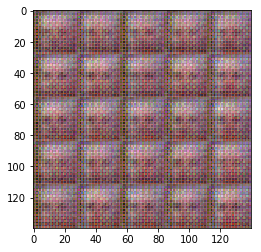

Epoch 0 The No. 110 steps loss_d is 0.6723302602767944 The No. 110 steps loss_g is 1.4507431983947754
Epoch 0 The No. 120 steps loss_d is 0.606826663017273 The No. 120 steps loss_g is 1.6578707695007324
Epoch 0 The No. 130 steps loss_d is 0.6923382878303528 The No. 130 steps loss_g is 1.3324699401855469
Epoch 0 The No. 140 steps loss_d is 0.7359116673469543 The No. 140 steps loss_g is 4.102331161499023
Epoch 0 The No. 150 steps loss_d is 0.5581332445144653 The No. 150 steps loss_g is 2.304760456085205
Epoch 0 The No. 160 steps loss_d is 0.7342036962509155 The No. 160 steps loss_g is 2.9100522994995117
Epoch 0 The No. 170 steps loss_d is 1.6570696830749512 The No. 170 steps loss_g is 0.3281477093696594
Epoch 0 The No. 180 steps loss_d is 1.303903341293335 The No. 180 steps loss_g is 0.6811416149139404
Epoch 0 The No. 190 steps loss_d is 0.8084380030632019 The No. 190 steps loss_g is 1.5491714477539062
Epoch 0 The No. 200 steps loss_d is 0.8403541445732117 The No. 200 steps loss_g is 1.4

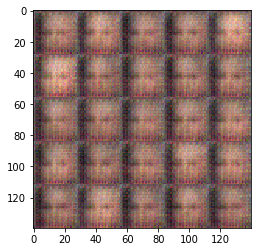

Epoch 0 The No. 210 steps loss_d is 1.2808022499084473 The No. 210 steps loss_g is 0.9370246529579163
Epoch 0 The No. 220 steps loss_d is 0.812475860118866 The No. 220 steps loss_g is 1.4047492742538452
Epoch 0 The No. 230 steps loss_d is 0.9909874200820923 The No. 230 steps loss_g is 1.2401341199874878
Epoch 0 The No. 240 steps loss_d is 0.9949681758880615 The No. 240 steps loss_g is 1.1981568336486816
Epoch 0 The No. 250 steps loss_d is 0.9266006350517273 The No. 250 steps loss_g is 1.352103590965271
Epoch 0 The No. 260 steps loss_d is 0.8982858061790466 The No. 260 steps loss_g is 1.5829081535339355
Epoch 0 The No. 270 steps loss_d is 0.6753869652748108 The No. 270 steps loss_g is 2.0301008224487305
Epoch 0 The No. 280 steps loss_d is 0.8229707479476929 The No. 280 steps loss_g is 1.5974152088165283
Epoch 0 The No. 290 steps loss_d is 0.6912475228309631 The No. 290 steps loss_g is 1.7195093631744385
Epoch 0 The No. 300 steps loss_d is 1.064415693283081 The No. 300 steps loss_g is 1.

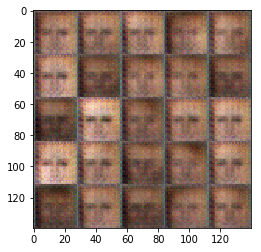

Epoch 0 The No. 310 steps loss_d is 0.9064332246780396 The No. 310 steps loss_g is 1.3530595302581787
Epoch 0 The No. 320 steps loss_d is 0.8972004652023315 The No. 320 steps loss_g is 1.609403133392334
Epoch 0 The No. 330 steps loss_d is 0.8432080745697021 The No. 330 steps loss_g is 1.27154541015625
Epoch 0 The No. 340 steps loss_d is 1.189345359802246 The No. 340 steps loss_g is 0.7243771553039551
Epoch 0 The No. 350 steps loss_d is 0.9097821712493896 The No. 350 steps loss_g is 1.3535747528076172
Epoch 0 The No. 360 steps loss_d is 1.0984349250793457 The No. 360 steps loss_g is 1.3521361351013184
Epoch 0 The No. 370 steps loss_d is 1.068772315979004 The No. 370 steps loss_g is 1.370593547821045
Epoch 0 The No. 380 steps loss_d is 0.8027516603469849 The No. 380 steps loss_g is 1.9855012893676758
Epoch 0 The No. 390 steps loss_d is 1.0339831113815308 The No. 390 steps loss_g is 1.4726089239120483
Epoch 0 The No. 400 steps loss_d is 1.082215666770935 The No. 400 steps loss_g is 1.2133

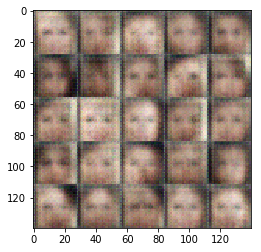

Epoch 0 The No. 410 steps loss_d is 0.9199190735816956 The No. 410 steps loss_g is 1.5937919616699219
Epoch 0 The No. 420 steps loss_d is 0.9518102407455444 The No. 420 steps loss_g is 1.3103291988372803
Epoch 0 The No. 430 steps loss_d is 0.8963779807090759 The No. 430 steps loss_g is 1.607535719871521
Epoch 0 The No. 440 steps loss_d is 1.074861764907837 The No. 440 steps loss_g is 1.7151694297790527
Epoch 0 The No. 450 steps loss_d is 1.4116647243499756 The No. 450 steps loss_g is 1.0627533197402954
Epoch 0 The No. 460 steps loss_d is 1.1586354970932007 The No. 460 steps loss_g is 1.189281940460205
Epoch 0 The No. 470 steps loss_d is 1.0408775806427002 The No. 470 steps loss_g is 1.3492794036865234
Epoch 0 The No. 480 steps loss_d is 1.2477271556854248 The No. 480 steps loss_g is 1.0087051391601562
Epoch 0 The No. 490 steps loss_d is 1.1525731086730957 The No. 490 steps loss_g is 1.0494022369384766
Epoch 0 The No. 500 steps loss_d is 1.4974745512008667 The No. 500 steps loss_g is 0.

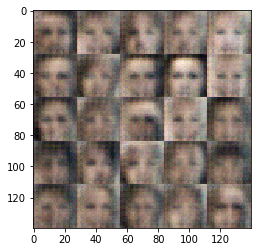

Epoch 0 The No. 510 steps loss_d is 0.9885252714157104 The No. 510 steps loss_g is 1.127893328666687
Epoch 0 The No. 520 steps loss_d is 1.3891141414642334 The No. 520 steps loss_g is 0.664443850517273
Epoch 0 The No. 530 steps loss_d is 1.1701617240905762 The No. 530 steps loss_g is 1.0432767868041992
Epoch 0 The No. 540 steps loss_d is 1.1336479187011719 The No. 540 steps loss_g is 1.02817964553833
Epoch 0 The No. 550 steps loss_d is 1.36884343624115 The No. 550 steps loss_g is 0.8198261260986328
Epoch 0 The No. 560 steps loss_d is 1.2251908779144287 The No. 560 steps loss_g is 0.8386760950088501
Epoch 0 The No. 570 steps loss_d is 1.5328344106674194 The No. 570 steps loss_g is 1.4813735485076904
Epoch 0 The No. 580 steps loss_d is 0.9639629125595093 The No. 580 steps loss_g is 1.2492103576660156
Epoch 0 The No. 590 steps loss_d is 1.4167559146881104 The No. 590 steps loss_g is 0.8368291854858398
Epoch 0 The No. 600 steps loss_d is 1.3045405149459839 The No. 600 steps loss_g is 0.789

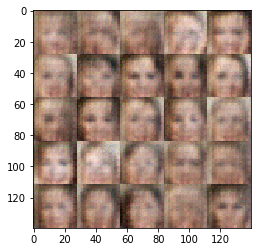

Epoch 0 The No. 610 steps loss_d is 1.0562890768051147 The No. 610 steps loss_g is 1.133004069328308
Epoch 0 The No. 620 steps loss_d is 1.3803871870040894 The No. 620 steps loss_g is 1.033313274383545
Epoch 0 The No. 630 steps loss_d is 1.242546558380127 The No. 630 steps loss_g is 0.9621053338050842
Epoch 0 The No. 640 steps loss_d is 1.1691081523895264 The No. 640 steps loss_g is 0.9610052108764648
Epoch 0 The No. 650 steps loss_d is 1.3501381874084473 The No. 650 steps loss_g is 0.624140739440918
Epoch 0 The No. 660 steps loss_d is 1.2781715393066406 The No. 660 steps loss_g is 0.9401155710220337
Epoch 0 The No. 670 steps loss_d is 1.3010356426239014 The No. 670 steps loss_g is 0.7902474403381348
Epoch 0 The No. 680 steps loss_d is 1.3336615562438965 The No. 680 steps loss_g is 0.7461192607879639
Epoch 0 The No. 690 steps loss_d is 1.3716073036193848 The No. 690 steps loss_g is 0.7496614456176758
Epoch 0 The No. 700 steps loss_d is 1.2025357484817505 The No. 700 steps loss_g is 1.1

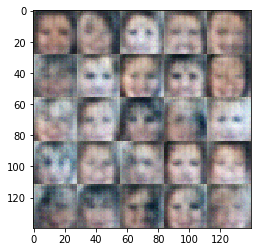

Epoch 0 The No. 710 steps loss_d is 1.592052698135376 The No. 710 steps loss_g is 0.958608865737915
Epoch 0 The No. 720 steps loss_d is 1.0883078575134277 The No. 720 steps loss_g is 1.2723588943481445
Epoch 0 The No. 730 steps loss_d is 1.1961331367492676 The No. 730 steps loss_g is 0.949512243270874
Epoch 0 The No. 740 steps loss_d is 1.4006657600402832 The No. 740 steps loss_g is 0.7746049165725708
Epoch 0 The No. 750 steps loss_d is 1.1592943668365479 The No. 750 steps loss_g is 0.9647834300994873
Epoch 0 The No. 760 steps loss_d is 1.3312458992004395 The No. 760 steps loss_g is 0.6559920310974121
Epoch 0 The No. 770 steps loss_d is 1.23069429397583 The No. 770 steps loss_g is 0.9323793649673462
Epoch 0 The No. 780 steps loss_d is 1.2922309637069702 The No. 780 steps loss_g is 0.8701406717300415
Epoch 0 The No. 790 steps loss_d is 1.1401724815368652 The No. 790 steps loss_g is 0.9640606641769409
Epoch 0 The No. 800 steps loss_d is 1.0969789028167725 The No. 800 steps loss_g is 1.16

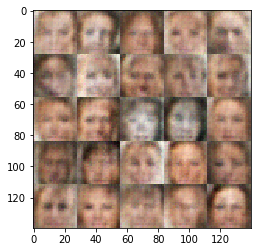

Epoch 0 The No. 810 steps loss_d is 1.2418150901794434 The No. 810 steps loss_g is 0.7601515054702759
Epoch 0 The No. 820 steps loss_d is 1.2115397453308105 The No. 820 steps loss_g is 0.8706016540527344
Epoch 0 The No. 830 steps loss_d is 1.2409271001815796 The No. 830 steps loss_g is 1.0395359992980957
Epoch 0 The No. 840 steps loss_d is 1.0553534030914307 The No. 840 steps loss_g is 1.1309585571289062
Epoch 0 The No. 850 steps loss_d is 1.0848548412322998 The No. 850 steps loss_g is 0.9233068227767944
Epoch 0 The No. 860 steps loss_d is 1.212623119354248 The No. 860 steps loss_g is 0.8456593155860901
Epoch 0 The No. 870 steps loss_d is 1.3277920484542847 The No. 870 steps loss_g is 1.0985908508300781
Epoch 0 The No. 880 steps loss_d is 1.129001259803772 The No. 880 steps loss_g is 1.4331958293914795
Epoch 0 The No. 890 steps loss_d is 0.9877256751060486 The No. 890 steps loss_g is 1.1295886039733887
Epoch 0 The No. 900 steps loss_d is 1.5660234689712524 The No. 900 steps loss_g is 0

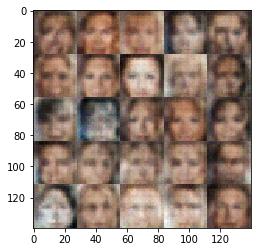

Epoch 0 The No. 910 steps loss_d is 1.0550379753112793 The No. 910 steps loss_g is 0.8086325526237488
Epoch 0 The No. 920 steps loss_d is 0.738701581954956 The No. 920 steps loss_g is 1.8610975742340088
Epoch 0 The No. 930 steps loss_d is 0.8048852682113647 The No. 930 steps loss_g is 2.6715638637542725
Epoch 0 The No. 940 steps loss_d is 0.6967858076095581 The No. 940 steps loss_g is 3.3627915382385254
Epoch 0 The No. 950 steps loss_d is 0.7360188364982605 The No. 950 steps loss_g is 3.061634063720703
Epoch 0 The No. 960 steps loss_d is 0.7210106253623962 The No. 960 steps loss_g is 1.29060697555542
Epoch 0 The No. 970 steps loss_d is 2.0499773025512695 The No. 970 steps loss_g is 4.154375076293945
Epoch 0 The No. 980 steps loss_d is 1.162407398223877 The No. 980 steps loss_g is 0.627899169921875
Epoch 0 The No. 990 steps loss_d is 0.9985593557357788 The No. 990 steps loss_g is 0.8285703063011169
Epoch 0 The No. 1000 steps loss_d is 1.3288021087646484 The No. 1000 steps loss_g is 0.48

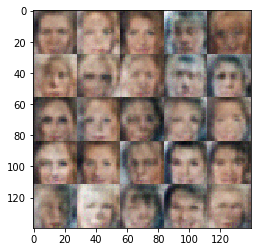

Epoch 0 The No. 1010 steps loss_d is 1.2010538578033447 The No. 1010 steps loss_g is 0.6037156581878662
Epoch 0 The No. 1020 steps loss_d is 0.823390007019043 The No. 1020 steps loss_g is 1.1401500701904297
Epoch 0 The No. 1030 steps loss_d is 0.7438759207725525 The No. 1030 steps loss_g is 2.926623821258545
Epoch 0 The No. 1040 steps loss_d is 0.8173533082008362 The No. 1040 steps loss_g is 1.033928394317627
Epoch 0 The No. 1050 steps loss_d is 0.5593337416648865 The No. 1050 steps loss_g is 2.754880428314209
Epoch 0 The No. 1060 steps loss_d is 0.5197314620018005 The No. 1060 steps loss_g is 3.1954543590545654
Epoch 0 The No. 1070 steps loss_d is 0.5193362832069397 The No. 1070 steps loss_g is 4.7192230224609375
Epoch 0 The No. 1080 steps loss_d is 0.8914921879768372 The No. 1080 steps loss_g is 1.2724885940551758
Epoch 0 The No. 1090 steps loss_d is 1.1301244497299194 The No. 1090 steps loss_g is 3.7962894439697266
Epoch 0 The No. 1100 steps loss_d is 0.5315551161766052 The No. 1100

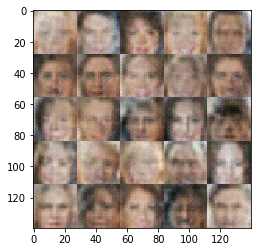

Epoch 0 The No. 1110 steps loss_d is 0.9413450360298157 The No. 1110 steps loss_g is 4.5579729080200195
Epoch 0 The No. 1120 steps loss_d is 1.0501707792282104 The No. 1120 steps loss_g is 1.610870361328125
Epoch 0 The No. 1130 steps loss_d is 1.4467108249664307 The No. 1130 steps loss_g is 0.651465892791748
Epoch 0 The No. 1140 steps loss_d is 0.7057814598083496 The No. 1140 steps loss_g is 1.883509874343872
Epoch 0 The No. 1150 steps loss_d is 0.6440536379814148 The No. 1150 steps loss_g is 2.920562982559204
Epoch 0 The No. 1160 steps loss_d is 0.7128684520721436 The No. 1160 steps loss_g is 1.7921974658966064
Epoch 0 The No. 1170 steps loss_d is 0.8191838264465332 The No. 1170 steps loss_g is 1.99888277053833
Epoch 0 The No. 1180 steps loss_d is 1.0161404609680176 The No. 1180 steps loss_g is 3.0788588523864746
Epoch 0 The No. 1190 steps loss_d is 1.3421704769134521 The No. 1190 steps loss_g is 0.5206525325775146
Epoch 0 The No. 1200 steps loss_d is 1.19974946975708 The No. 1200 ste

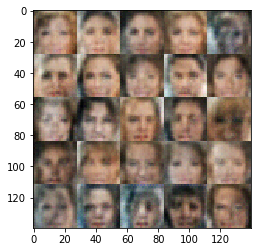

Epoch 0 The No. 1210 steps loss_d is 1.1243603229522705 The No. 1210 steps loss_g is 0.9792383909225464
Epoch 0 The No. 1220 steps loss_d is 1.0641276836395264 The No. 1220 steps loss_g is 0.8585428595542908
Epoch 0 The No. 1230 steps loss_d is 0.6535927653312683 The No. 1230 steps loss_g is 1.8860433101654053
Epoch 0 The No. 1240 steps loss_d is 1.44211745262146 The No. 1240 steps loss_g is 0.45255130529403687
Epoch 0 The No. 1250 steps loss_d is 1.0817604064941406 The No. 1250 steps loss_g is 1.8733203411102295
Epoch 0 The No. 1260 steps loss_d is 0.6036649942398071 The No. 1260 steps loss_g is 2.0112669467926025
Epoch 0 The No. 1270 steps loss_d is 0.7127076387405396 The No. 1270 steps loss_g is 1.331127643585205
Epoch 0 The No. 1280 steps loss_d is 1.7832086086273193 The No. 1280 steps loss_g is 0.3014630675315857
Epoch 0 The No. 1290 steps loss_d is 0.7899137139320374 The No. 1290 steps loss_g is 1.9752686023712158
Epoch 0 The No. 1300 steps loss_d is 0.9659211039543152 The No. 13

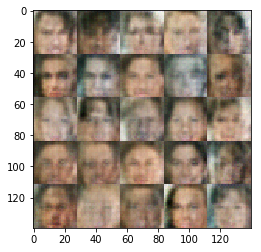

Epoch 0 The No. 1310 steps loss_d is 1.126504898071289 The No. 1310 steps loss_g is 0.8746612071990967
Epoch 0 The No. 1320 steps loss_d is 0.9254870414733887 The No. 1320 steps loss_g is 1.4210556745529175
Epoch 0 The No. 1330 steps loss_d is 1.468773365020752 The No. 1330 steps loss_g is 0.44285857677459717
Epoch 0 The No. 1340 steps loss_d is 1.4688599109649658 The No. 1340 steps loss_g is 0.4910676181316376
Epoch 0 The No. 1350 steps loss_d is 1.6061872243881226 The No. 1350 steps loss_g is 0.4342579245567322
Epoch 0 The No. 1360 steps loss_d is 1.4773907661437988 The No. 1360 steps loss_g is 0.45175468921661377
Epoch 0 The No. 1370 steps loss_d is 1.050343632698059 The No. 1370 steps loss_g is 0.7995185256004333
Epoch 0 The No. 1380 steps loss_d is 0.9137400388717651 The No. 1380 steps loss_g is 1.2098770141601562
Epoch 0 The No. 1390 steps loss_d is 1.1158912181854248 The No. 1390 steps loss_g is 0.7900038361549377
Epoch 0 The No. 1400 steps loss_d is 1.0129716396331787 The No. 1

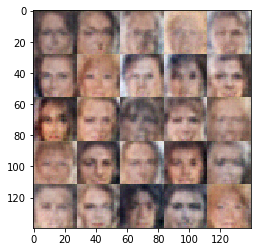

Epoch 0 The No. 1410 steps loss_d is 1.0688862800598145 The No. 1410 steps loss_g is 1.092197299003601
Epoch 0 The No. 1420 steps loss_d is 1.3269813060760498 The No. 1420 steps loss_g is 0.6528198719024658
Epoch 0 The No. 1430 steps loss_d is 0.925605297088623 The No. 1430 steps loss_g is 1.888007402420044
Epoch 0 The No. 1440 steps loss_d is 1.175707459449768 The No. 1440 steps loss_g is 0.7943300008773804
Epoch 0 The No. 1450 steps loss_d is 1.285710096359253 The No. 1450 steps loss_g is 0.8237901926040649
Epoch 0 The No. 1460 steps loss_d is 0.8668031692504883 The No. 1460 steps loss_g is 1.702690601348877
Epoch 0 The No. 1470 steps loss_d is 0.770943284034729 The No. 1470 steps loss_g is 1.5455994606018066
Epoch 0 The No. 1480 steps loss_d is 1.0823137760162354 The No. 1480 steps loss_g is 0.8511784672737122
Epoch 0 The No. 1490 steps loss_d is 1.1882455348968506 The No. 1490 steps loss_g is 0.7799144387245178
Epoch 0 The No. 1500 steps loss_d is 0.9262281060218811 The No. 1500 st

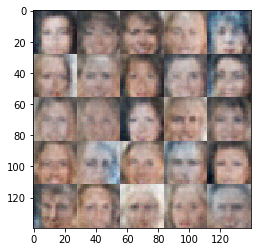

Epoch 0 The No. 1510 steps loss_d is 0.9065694808959961 The No. 1510 steps loss_g is 0.9427428245544434
Epoch 0 The No. 1520 steps loss_d is 0.8106904625892639 The No. 1520 steps loss_g is 1.1229441165924072
Epoch 0 The No. 1530 steps loss_d is 0.6547501683235168 The No. 1530 steps loss_g is 2.428903818130493
Epoch 0 The No. 1540 steps loss_d is 1.2327821254730225 The No. 1540 steps loss_g is 0.8495833873748779
Epoch 0 The No. 1550 steps loss_d is 0.8050532937049866 The No. 1550 steps loss_g is 1.528468132019043
Epoch 0 The No. 1560 steps loss_d is 1.2009022235870361 The No. 1560 steps loss_g is 0.6047809720039368
Epoch 0 The No. 1570 steps loss_d is 0.7561376094818115 The No. 1570 steps loss_g is 1.4845645427703857
Epoch 0 The No. 1580 steps loss_d is 1.2282942533493042 The No. 1580 steps loss_g is 0.5789520144462585
Epoch 0 The No. 1590 steps loss_d is 1.1891653537750244 The No. 1590 steps loss_g is 0.7371706366539001
Epoch 0 The No. 1600 steps loss_d is 0.8983994722366333 The No. 16

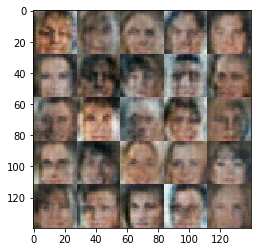

Epoch 0 The No. 1610 steps loss_d is 1.1384378671646118 The No. 1610 steps loss_g is 0.6411874294281006
Epoch 0 The No. 1620 steps loss_d is 0.8963381052017212 The No. 1620 steps loss_g is 1.1556318998336792
Epoch 0 The No. 1630 steps loss_d is 0.5169239044189453 The No. 1630 steps loss_g is 2.816981792449951
Epoch 0 The No. 1640 steps loss_d is 0.8282465934753418 The No. 1640 steps loss_g is 1.3287650346755981
Epoch 0 The No. 1650 steps loss_d is 0.7219532132148743 The No. 1650 steps loss_g is 1.5207359790802002
Epoch 0 The No. 1660 steps loss_d is 0.898368239402771 The No. 1660 steps loss_g is 1.073269009590149
Epoch 0 The No. 1670 steps loss_d is 0.641508162021637 The No. 1670 steps loss_g is 1.8676996231079102
Epoch 0 The No. 1680 steps loss_d is 0.5723088383674622 The No. 1680 steps loss_g is 3.674912929534912
Epoch 0 The No. 1690 steps loss_d is 0.6908931136131287 The No. 1690 steps loss_g is 2.4219889640808105
Epoch 0 The No. 1700 steps loss_d is 1.3095247745513916 The No. 1700 

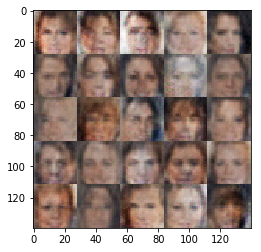

Epoch 0 The No. 1710 steps loss_d is 0.6729419827461243 The No. 1710 steps loss_g is 4.108509063720703
Epoch 0 The No. 1720 steps loss_d is 0.5452803373336792 The No. 1720 steps loss_g is 2.074169635772705
Epoch 0 The No. 1730 steps loss_d is 0.6765132546424866 The No. 1730 steps loss_g is 1.7080605030059814
Epoch 0 The No. 1740 steps loss_d is 0.46637222170829773 The No. 1740 steps loss_g is 3.2915751934051514
Epoch 0 The No. 1750 steps loss_d is 0.7520067095756531 The No. 1750 steps loss_g is 2.6717727184295654
Epoch 0 The No. 1760 steps loss_d is 0.41125962138175964 The No. 1760 steps loss_g is 5.1817169189453125
Epoch 0 The No. 1770 steps loss_d is 0.4048248827457428 The No. 1770 steps loss_g is 3.4908864498138428
Epoch 0 The No. 1780 steps loss_d is 0.7876164317131042 The No. 1780 steps loss_g is 1.708095908164978
Epoch 0 The No. 1790 steps loss_d is 1.1747589111328125 The No. 1790 steps loss_g is 0.8567622303962708
Epoch 0 The No. 1800 steps loss_d is 1.328371286392212 The No. 18

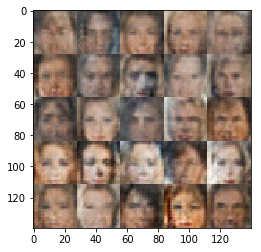

Epoch 0 The No. 1810 steps loss_d is 0.5574002265930176 The No. 1810 steps loss_g is 2.0705740451812744
Epoch 0 The No. 1820 steps loss_d is 0.5642974376678467 The No. 1820 steps loss_g is 3.0657718181610107
Epoch 0 The No. 1830 steps loss_d is 0.9924634695053101 The No. 1830 steps loss_g is 0.8466380834579468
Epoch 0 The No. 1840 steps loss_d is 0.7178051471710205 The No. 1840 steps loss_g is 2.1493008136749268
Epoch 0 The No. 1850 steps loss_d is 0.4697553217411041 The No. 1850 steps loss_g is 4.187028884887695
Epoch 0 The No. 1860 steps loss_d is 0.8361735343933105 The No. 1860 steps loss_g is 1.189590573310852
Epoch 0 The No. 1870 steps loss_d is 0.5272849798202515 The No. 1870 steps loss_g is 4.554391860961914
Epoch 0 The No. 1880 steps loss_d is 0.61190265417099 The No. 1880 steps loss_g is 4.779005527496338
Epoch 0 The No. 1890 steps loss_d is 0.40330415964126587 The No. 1890 steps loss_g is 3.102290153503418
Epoch 0 The No. 1900 steps loss_d is 0.6424239277839661 The No. 1900 s

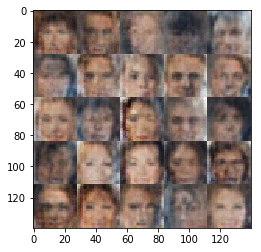

Epoch 0 The No. 1910 steps loss_d is 0.5312243700027466 The No. 1910 steps loss_g is 5.450272560119629
Epoch 0 The No. 1920 steps loss_d is 1.8367952108383179 The No. 1920 steps loss_g is 0.2892031669616699
Epoch 0 The No. 1930 steps loss_d is 0.776321291923523 The No. 1930 steps loss_g is 3.8072609901428223
Epoch 0 The No. 1940 steps loss_d is 0.6084109544754028 The No. 1940 steps loss_g is 4.683081150054932
Epoch 0 The No. 1950 steps loss_d is 0.6181910037994385 The No. 1950 steps loss_g is 1.7683558464050293
Epoch 0 The No. 1960 steps loss_d is 0.5189931988716125 The No. 1960 steps loss_g is 3.0360682010650635
Epoch 0 The No. 1970 steps loss_d is 0.4225110411643982 The No. 1970 steps loss_g is 3.7929368019104004
Epoch 0 The No. 1980 steps loss_d is 0.4603368043899536 The No. 1980 steps loss_g is 2.6489453315734863
Epoch 0 The No. 1990 steps loss_d is 0.441808819770813 The No. 1990 steps loss_g is 2.9192447662353516
Epoch 0 The No. 2000 steps loss_d is 0.4393446147441864 The No. 2000

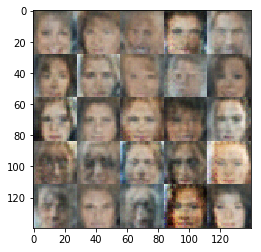

Epoch 0 The No. 2010 steps loss_d is 0.9835355281829834 The No. 2010 steps loss_g is 1.587781548500061
Epoch 0 The No. 2020 steps loss_d is 0.7900559902191162 The No. 2020 steps loss_g is 1.2343952655792236
Epoch 0 The No. 2030 steps loss_d is 0.9376491904258728 The No. 2030 steps loss_g is 1.6224339008331299
Epoch 0 The No. 2040 steps loss_d is 0.9124807715415955 The No. 2040 steps loss_g is 2.9336180686950684
Epoch 0 The No. 2050 steps loss_d is 0.3678708076477051 The No. 2050 steps loss_g is 3.890745162963867
Epoch 0 The No. 2060 steps loss_d is 0.761976957321167 The No. 2060 steps loss_g is 1.5552289485931396
Epoch 0 The No. 2070 steps loss_d is 0.4316588044166565 The No. 2070 steps loss_g is 5.117415428161621
Epoch 0 The No. 2080 steps loss_d is 0.4032513499259949 The No. 2080 steps loss_g is 5.413477897644043
Epoch 0 The No. 2090 steps loss_d is 0.7469619512557983 The No. 2090 steps loss_g is 2.69120454788208
Epoch 0 The No. 2100 steps loss_d is 0.4533609449863434 The No. 2100 st

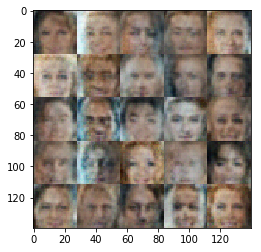

Epoch 0 The No. 2110 steps loss_d is 0.7085779905319214 The No. 2110 steps loss_g is 2.013425827026367
Epoch 0 The No. 2120 steps loss_d is 0.4788602590560913 The No. 2120 steps loss_g is 5.477097511291504
Epoch 0 The No. 2130 steps loss_d is 0.5640190839767456 The No. 2130 steps loss_g is 6.322364807128906
Epoch 0 The No. 2140 steps loss_d is 0.7153323888778687 The No. 2140 steps loss_g is 2.1249923706054688
Epoch 0 The No. 2150 steps loss_d is 0.36292776465415955 The No. 2150 steps loss_g is 7.137874126434326
Epoch 0 The No. 2160 steps loss_d is 0.3756456971168518 The No. 2160 steps loss_g is 4.921357154846191
Epoch 0 The No. 2170 steps loss_d is 0.36809033155441284 The No. 2170 steps loss_g is 5.070240020751953
Epoch 0 The No. 2180 steps loss_d is 1.3613065481185913 The No. 2180 steps loss_g is 0.5013481378555298
Epoch 0 The No. 2190 steps loss_d is 0.9836388826370239 The No. 2190 steps loss_g is 8.441624641418457
Epoch 0 The No. 2200 steps loss_d is 0.9039828777313232 The No. 2200 

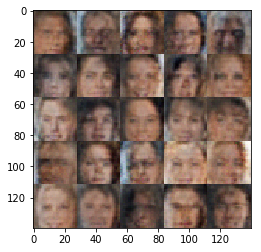

Epoch 0 The No. 2210 steps loss_d is 0.376224160194397 The No. 2210 steps loss_g is 4.305936813354492
Epoch 0 The No. 2220 steps loss_d is 0.46083614230155945 The No. 2220 steps loss_g is 3.8930206298828125
Epoch 0 The No. 2230 steps loss_d is 0.5771490335464478 The No. 2230 steps loss_g is 2.6091418266296387
Epoch 0 The No. 2240 steps loss_d is 0.3926977813243866 The No. 2240 steps loss_g is 3.8967370986938477
Epoch 0 The No. 2250 steps loss_d is 0.6701109409332275 The No. 2250 steps loss_g is 1.4352538585662842
Epoch 0 The No. 2260 steps loss_d is 0.7448244690895081 The No. 2260 steps loss_g is 1.620680570602417
Epoch 0 The No. 2270 steps loss_d is 0.9100732803344727 The No. 2270 steps loss_g is 0.9824228286743164
Epoch 0 The No. 2280 steps loss_d is 0.42854273319244385 The No. 2280 steps loss_g is 7.620757579803467
Epoch 0 The No. 2290 steps loss_d is 0.5365850329399109 The No. 2290 steps loss_g is 4.534028053283691
Epoch 0 The No. 2300 steps loss_d is 0.3955981135368347 The No. 230

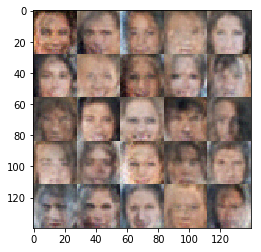

Epoch 0 The No. 2310 steps loss_d is 1.0164915323257446 The No. 2310 steps loss_g is 0.9439414739608765
Epoch 0 The No. 2320 steps loss_d is 0.610657274723053 The No. 2320 steps loss_g is 3.546868324279785
Epoch 0 The No. 2330 steps loss_d is 0.4361170530319214 The No. 2330 steps loss_g is 2.7366132736206055
Epoch 0 The No. 2340 steps loss_d is 0.6517238020896912 The No. 2340 steps loss_g is 2.0714304447174072
Epoch 0 The No. 2350 steps loss_d is 0.4120822846889496 The No. 2350 steps loss_g is 5.4642157554626465
Epoch 0 The No. 2360 steps loss_d is 0.43614357709884644 The No. 2360 steps loss_g is 3.046811580657959
Epoch 0 The No. 2370 steps loss_d is 0.37560683488845825 The No. 2370 steps loss_g is 5.78364372253418
Epoch 0 The No. 2380 steps loss_d is 0.7506550550460815 The No. 2380 steps loss_g is 1.3076149225234985
Epoch 0 The No. 2390 steps loss_d is 0.8296757936477661 The No. 2390 steps loss_g is 5.314735412597656
Epoch 0 The No. 2400 steps loss_d is 0.47022902965545654 The No. 240

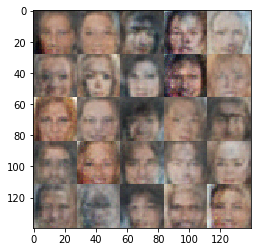

Epoch 0 The No. 2410 steps loss_d is 0.7462449073791504 The No. 2410 steps loss_g is 1.1957409381866455
Epoch 0 The No. 2420 steps loss_d is 0.5893839001655579 The No. 2420 steps loss_g is 3.34159517288208
Epoch 0 The No. 2430 steps loss_d is 0.48329976201057434 The No. 2430 steps loss_g is 5.279343605041504
Epoch 0 The No. 2440 steps loss_d is 0.6790082454681396 The No. 2440 steps loss_g is 1.68161940574646
Epoch 0 The No. 2450 steps loss_d is 0.7107400894165039 The No. 2450 steps loss_g is 1.454904556274414
Epoch 0 The No. 2460 steps loss_d is 0.4565794765949249 The No. 2460 steps loss_g is 3.442718982696533
Epoch 0 The No. 2470 steps loss_d is 0.48725444078445435 The No. 2470 steps loss_g is 2.2135305404663086
Epoch 0 The No. 2480 steps loss_d is 0.5880035161972046 The No. 2480 steps loss_g is 5.6467485427856445
Epoch 0 The No. 2490 steps loss_d is 0.38907769322395325 The No. 2490 steps loss_g is 3.527313709259033
Epoch 0 The No. 2500 steps loss_d is 0.44205400347709656 The No. 2500

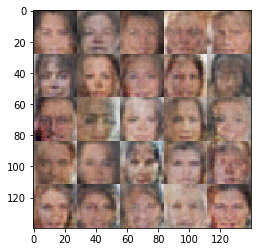

Epoch 0 The No. 2510 steps loss_d is 1.4810938835144043 The No. 2510 steps loss_g is 0.4246981739997864
Epoch 0 The No. 2520 steps loss_d is 0.594772219657898 The No. 2520 steps loss_g is 6.80357027053833
Epoch 0 The No. 2530 steps loss_d is 0.4132470488548279 The No. 2530 steps loss_g is 4.045993328094482
Epoch 0 The No. 2540 steps loss_d is 0.5808601975440979 The No. 2540 steps loss_g is 3.484905242919922
Epoch 0 The No. 2550 steps loss_d is 0.45306071639060974 The No. 2550 steps loss_g is 4.163662910461426
Epoch 0 The No. 2560 steps loss_d is 0.8521576523780823 The No. 2560 steps loss_g is 1.2087746858596802
Epoch 0 The No. 2570 steps loss_d is 0.48757031559944153 The No. 2570 steps loss_g is 2.464090347290039
Epoch 0 The No. 2580 steps loss_d is 0.4358348250389099 The No. 2580 steps loss_g is 3.266226291656494
Epoch 0 The No. 2590 steps loss_d is 0.7577820420265198 The No. 2590 steps loss_g is 1.24443519115448
Epoch 0 The No. 2600 steps loss_d is 0.7460849285125732 The No. 2600 ste

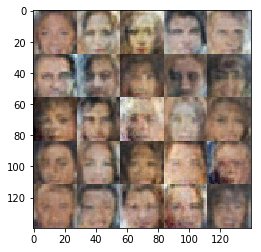

Epoch 0 The No. 2610 steps loss_d is 0.4183502197265625 The No. 2610 steps loss_g is 3.446049213409424
Epoch 0 The No. 2620 steps loss_d is 0.46310946345329285 The No. 2620 steps loss_g is 2.554068088531494
Epoch 0 The No. 2630 steps loss_d is 0.467327356338501 The No. 2630 steps loss_g is 4.766317367553711
Epoch 0 The No. 2640 steps loss_d is 0.5606709718704224 The No. 2640 steps loss_g is 1.9822062253952026
Epoch 0 The No. 2650 steps loss_d is 1.381432056427002 The No. 2650 steps loss_g is 0.4944860637187958
Epoch 0 The No. 2660 steps loss_d is 0.9072456955909729 The No. 2660 steps loss_g is 1.08249032497406
Epoch 0 The No. 2670 steps loss_d is 0.501144289970398 The No. 2670 steps loss_g is 6.331519603729248
Epoch 0 The No. 2680 steps loss_d is 1.6210825443267822 The No. 2680 steps loss_g is 0.39522749185562134
Epoch 0 The No. 2690 steps loss_d is 0.6438800096511841 The No. 2690 steps loss_g is 2.584425926208496
Epoch 0 The No. 2700 steps loss_d is 0.5206142663955688 The No. 2700 ste

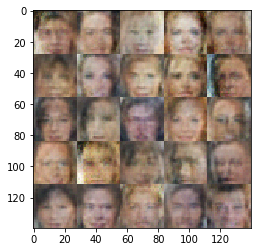

Epoch 0 The No. 2710 steps loss_d is 0.4642510712146759 The No. 2710 steps loss_g is 3.1320242881774902
Epoch 0 The No. 2720 steps loss_d is 0.5232279300689697 The No. 2720 steps loss_g is 2.0768496990203857
Epoch 0 The No. 2730 steps loss_d is 0.47214752435684204 The No. 2730 steps loss_g is 5.104950904846191
Epoch 0 The No. 2740 steps loss_d is 0.7067612409591675 The No. 2740 steps loss_g is 1.3718693256378174
Epoch 0 The No. 2750 steps loss_d is 0.4871867299079895 The No. 2750 steps loss_g is 3.270077705383301
Epoch 0 The No. 2760 steps loss_d is 0.7139366269111633 The No. 2760 steps loss_g is 1.438841700553894
Epoch 0 The No. 2770 steps loss_d is 0.875115692615509 The No. 2770 steps loss_g is 0.9456478357315063
Epoch 0 The No. 2780 steps loss_d is 0.3692343235015869 The No. 2780 steps loss_g is 5.231194496154785
Epoch 0 The No. 2790 steps loss_d is 0.5154421329498291 The No. 2790 steps loss_g is 2.9249258041381836
Epoch 0 The No. 2800 steps loss_d is 0.7108040452003479 The No. 2800

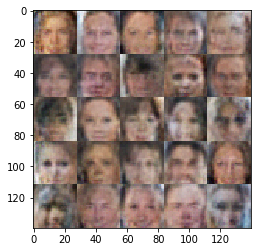

Epoch 0 The No. 2810 steps loss_d is 0.5762759447097778 The No. 2810 steps loss_g is 3.4422807693481445
Epoch 0 The No. 2820 steps loss_d is 0.47109824419021606 The No. 2820 steps loss_g is 3.8164196014404297
Epoch 0 The No. 2830 steps loss_d is 0.6535714268684387 The No. 2830 steps loss_g is 1.571120262145996
Epoch 0 The No. 2840 steps loss_d is 0.5223600268363953 The No. 2840 steps loss_g is 3.6214776039123535
Epoch 0 The No. 2850 steps loss_d is 0.653780996799469 The No. 2850 steps loss_g is 1.7726200819015503
Epoch 0 The No. 2860 steps loss_d is 0.47854670882225037 The No. 2860 steps loss_g is 4.849421501159668
Epoch 0 The No. 2870 steps loss_d is 1.0336120128631592 The No. 2870 steps loss_g is 0.8120039701461792
Epoch 0 The No. 2880 steps loss_d is 0.6275480389595032 The No. 2880 steps loss_g is 1.9641215801239014
Epoch 0 The No. 2890 steps loss_d is 0.8053537607192993 The No. 2890 steps loss_g is 1.0879813432693481
Epoch 0 The No. 2900 steps loss_d is 0.5555035471916199 The No. 2

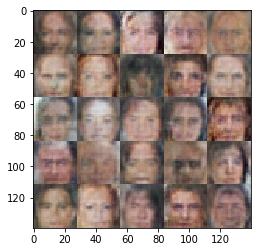

Epoch 0 The No. 2910 steps loss_d is 0.4142671823501587 The No. 2910 steps loss_g is 3.102445363998413
Epoch 0 The No. 2920 steps loss_d is 0.5205233693122864 The No. 2920 steps loss_g is 2.7651591300964355
Epoch 0 The No. 2930 steps loss_d is 0.6478121280670166 The No. 2930 steps loss_g is 3.593587636947632
Epoch 0 The No. 2940 steps loss_d is 0.4234922528266907 The No. 2940 steps loss_g is 3.2589304447174072
Epoch 0 The No. 2950 steps loss_d is 0.4673003554344177 The No. 2950 steps loss_g is 5.045419692993164
Epoch 0 The No. 2960 steps loss_d is 0.40815383195877075 The No. 2960 steps loss_g is 3.2514166831970215
Epoch 0 The No. 2970 steps loss_d is 0.7251003384590149 The No. 2970 steps loss_g is 1.7610716819763184
Epoch 0 The No. 2980 steps loss_d is 0.49882766604423523 The No. 2980 steps loss_g is 2.1872823238372803
Epoch 0 The No. 2990 steps loss_d is 0.35637736320495605 The No. 2990 steps loss_g is 6.463778495788574
Epoch 0 The No. 3000 steps loss_d is 0.47563454508781433 The No. 

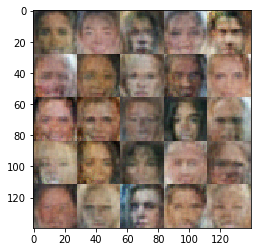

Epoch 0 The No. 3010 steps loss_d is 0.4308798611164093 The No. 3010 steps loss_g is 4.746774673461914
Epoch 0 The No. 3020 steps loss_d is 0.4198446273803711 The No. 3020 steps loss_g is 5.161513328552246
Epoch 0 The No. 3030 steps loss_d is 0.8349563479423523 The No. 3030 steps loss_g is 1.1513035297393799
Epoch 0 The No. 3040 steps loss_d is 0.47415414452552795 The No. 3040 steps loss_g is 2.320117473602295
Epoch 0 The No. 3050 steps loss_d is 0.4922165274620056 The No. 3050 steps loss_g is 2.9944100379943848
Epoch 0 The No. 3060 steps loss_d is 0.43234336376190186 The No. 3060 steps loss_g is 2.8230795860290527
Epoch 0 The No. 3070 steps loss_d is 0.4242570996284485 The No. 3070 steps loss_g is 5.354731559753418
Epoch 0 The No. 3080 steps loss_d is 0.39417821168899536 The No. 3080 steps loss_g is 4.650018215179443
Epoch 0 The No. 3090 steps loss_d is 0.43137994408607483 The No. 3090 steps loss_g is 3.366839647293091
Epoch 0 The No. 3100 steps loss_d is 0.8620352745056152 The No. 31

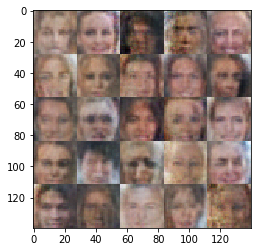

Epoch 0 The No. 3110 steps loss_d is 0.7814054489135742 The No. 3110 steps loss_g is 1.2416391372680664
Epoch 0 The No. 3120 steps loss_d is 0.5713738799095154 The No. 3120 steps loss_g is 2.641861915588379
Epoch 0 The No. 3130 steps loss_d is 0.4935944676399231 The No. 3130 steps loss_g is 2.5339410305023193
Epoch 0 The No. 3140 steps loss_d is 0.4838716387748718 The No. 3140 steps loss_g is 4.873782157897949
Epoch 0 The No. 3150 steps loss_d is 0.7021346092224121 The No. 3150 steps loss_g is 1.7282932996749878
Epoch 0 The No. 3160 steps loss_d is 0.4636777639389038 The No. 3160 steps loss_g is 2.7520129680633545


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.